In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from sklearn.svm import OneClassSVM
import joblib
import matplotlib.pyplot as plt

In [66]:
# Set dataset path
DATASET_PATH = "D:/Deep learning/mvtec_anomaly_detection"
IMAGE_SIZE = (128, 128)  # Resize to avoid memory issues

# Load Pretrained ResNet50 as Feature Extractor
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

In [67]:

# Set dataset path
DATASET_PATH = "D:/Deep learning/mvtec_anomaly_detection"
PROCESSED_PATH = "processed_data"
IMAGE_SIZE = (128, 128)  # Reduce size to avoid memory issues

# Create processed folder if not exists
if not os.path.exists(PROCESSED_PATH):
    os.makedirs(PROCESSED_PATH)


In [68]:

def extract_features(img):
    """Ensure consistent preprocessing for both file paths & Streamlit uploads."""
    
    if isinstance(img, str):  # If it's a file path
        img = image.load_img(img, target_size=IMAGE_SIZE)
    else:  # If it's a Streamlit upload
        img = img.convert("RGB")  # Ensure 3 channels
        img = img.resize(IMAGE_SIZE)

    img_array = np.array(img, dtype=np.float32)  # 🔥 Explicitly convert to float32
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # **🔥 Ensure preprocess_input was used during training**
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)  

    features = feature_extractor.predict(img_array)
    return features.flatten()  # Convert to 1D feature vector


In [33]:
def load_good_images():
    """Load and preprocess only 'good' images for training."""
    data = []
    
    for category in os.listdir(DATASET_PATH):
        category_path = os.path.join(DATASET_PATH, category, 'train', 'good')
        
        if not os.path.exists(category_path) or not os.path.isdir(category_path):
            continue
        
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            if is_image_file(img_name):
                features = extract_features(img_path)
                data.append(features)

    return np.array(data)

# Load good images and extract features
print("🔄 Loading and extracting features from good images...")
good_features = load_good_images()
print(f"✅ Total Good Images Processed: {len(good_features)}")


🔄 Loading and extracting features from good images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

In [63]:
# Train One-Class SVM
print("🔄 Training One-Class SVM...")
svm_model = OneClassSVM(kernel="rbf", gamma="auto", nu=0.01)
svm_model.fit(good_features)

# Save the trained model
joblib.dump(svm_model, "svm_model.pkl")
print("✅ SVM Model Saved as svm_model.pkl")

# Load trained SVM model
svm_model = joblib.load("svm_model.pkl")

🔄 Training One-Class SVM...
✅ SVM Model Saved as svm_model.pkl


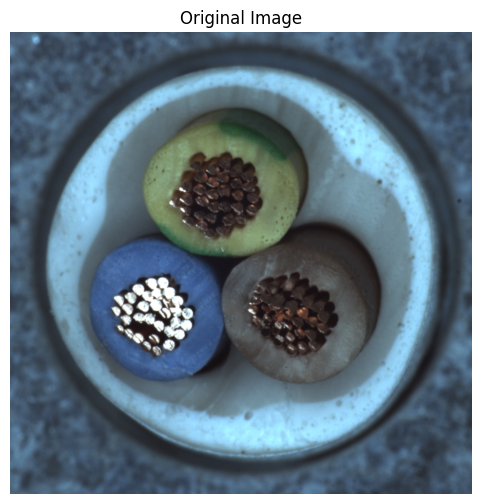

🔍 Testing Anomaly Detection...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
✅ Good Image


In [83]:

def detect_anomaly(img_path):
    """Predict if an image is an anomaly."""
    features = extract_features(img_path)
    prediction = svm_model.predict([features])  # 1 = Normal, -1 = Anomaly
     # Convert to DataFrame for better view
    
    if prediction[0] == 1:
        print("✅ Good Image")
    else:
        print("❌ Defective Image Detected!")

# Test on a new image


test_img_path = "D:/CNN Project/mvtec_anomaly_detection/cable/test/good/003.png"

# Load and display the image correctly
img = cv2.imread(test_img_path)  # Read image (BGR format)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

plt.figure(figsize=(6, 6))
plt.imshow(img)  # Now passing the correct image array
plt.axis("off")
plt.title("Original Image")
plt.show()

print("🔍 Testing Anomaly Detection...")
detect_anomaly(test_img_path)
